In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats

In [30]:
from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo = False)

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [86]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [87]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [89]:
# Get a list of column names and types
measure_columns = inspector.get_columns('measurement')
for c in measure_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [90]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [53]:
year_ago = dt.date(2018,5,23) - dt.timedelta(days= 365)
print(year_ago)

2017-05-23


In [92]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 5, 23) - dt.timedelta(days = 365)
print("Query Date: ", query_date)

Query Date:  2016-05-23


In [93]:
# Perform a query to retrieve the date and precipitation scores
sel = [Measurement.date,Measurement.prcp]
query_table = session.query(*sel).filter(Measurement.date >= query_date).all()

In [94]:
# Sort the dataframe by date
precipitation_df = pd.DataFrame(query_table, columns = ['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how = 'any')
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)

In [95]:
precipitation_df = precipitation_df.set_index("Date")
precipitation_df

,Precipitation
Date,
2016-05-23,0.00
2016-05-23,0.00
2016-05-23,0.11
2016-05-23,0.00
2016-05-23,0.00
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


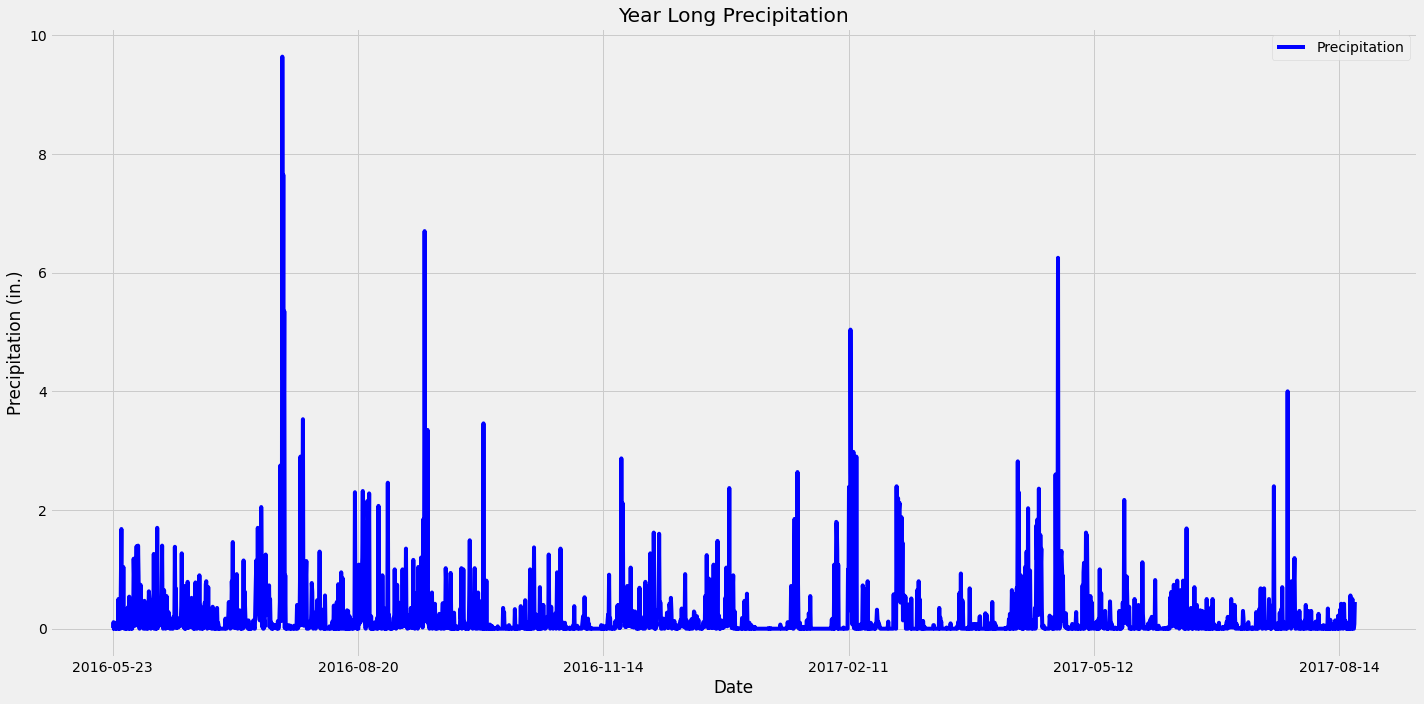

In [105]:
# Plot the results using the DataFrame plot method.
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True, color = "blue")

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("precipitation1.png")

#plot
plt.tight_layout()
plt.show()

In [106]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2533.000000
mean,0.199305
std,0.533563
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [107]:
# Get a list of column names and types
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [108]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Station).count()
print(f"There are {station_number} stations")

There are 9 stations


In [109]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [110]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
usc281_data = session.query(*sel).filter(Measurement.station == "USC00519281").all()
usc281_data

[(54.0, 85.0, 71.66378066378067)]

In [111]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date,Measurement.tobs]
query_table = session.query(*sel).filter(Measurement.date >= query_date).\
                                  filter(Measurement.station == "USC00519281").\
                                  order_by(Measurement.date).all()

In [112]:
# Create pandas df and sort temp in asc order
usc9281_df = pd.DataFrame(query_table, columns = ['Date','TOBS'])
usc9281_df = usc9281_df.dropna(how = 'any')
usc9281_df = usc9281_df.set_index("Date")
usc9281_df

,TOBS
Date,
2016-05-23,74.0
2016-05-24,69.0
2016-05-25,71.0
2016-05-26,74.0
2016-05-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


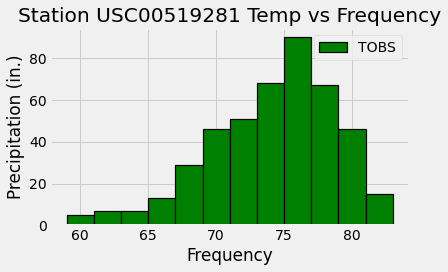

In [115]:
# Plot the Results as a Histogram with `bins=12`
usc9281_df.plot.hist(bins = 12, title= "Station USC00519281 Temp vs Frequency",
                    color = "green", edgecolor='black', linewidth=1.2)

#title and labels
plt.xlabel('Frequency')
plt.ylabel('Precipitation (in.)')

plt.savefig("tempvsfreq1.png")

#plot
plt.tight_layout()
plt.show()